In [2145]:
import numpy as np
np.set_printoptions(precision=4)
from scipy.stats import norm, multivariate_normal as mvn
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['axes.linewidth'] = 3
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.titlepad'] = 8.0
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.major.width'] = 3
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['lines.markersize'] = 5
mpl.rcParams['lines.linewidth'] = 5
mpl.rcParams['legend.fontsize'] = 15

In [2146]:

class OnlineEmpiricalCDF:
    def __init__(self, n_cdfs, n_bins=40000, value_range=(-1.0, 1.0)):
        """
        n_cdfs: number of CDFs to track (e.g., number of projection directions)
        n_bins: number of histogram bins
        value_range: (min_val, max_val) range of expected values
        """
        self.K = n_cdfs
        self.n_bins = n_bins
        self.vmin, self.vmax = value_range

        self.bin_edges = np.linspace(self.vmin, self.vmax, n_bins + 1)
        self.bin_counts = np.zeros((self.K, n_bins), dtype=np.int32)
        self.total_counts = np.zeros(self.K, dtype=np.int32)

    def _bin_indices(self, values):
        # Map values to histogram bin indices
        scaled = (values - self.vmin) / (self.vmax - self.vmin)
        indices = np.floor(scaled * self.n_bins).astype(np.int32)
        return np.clip(indices, 0, self.n_bins - 1)

    def update(self, values):
        """
        values: array of shape (K,) — new projected values (one per CDF)
        """
        assert values.shape == (self.K,), "Input must have shape (n_cdfs,)"
        indices = self._bin_indices(values)
        for k in range(self.K):
            self.bin_counts[k, indices[k]] += 1
            self.total_counts[k] += 1

    def query(self, values):
        """
        values: array of shape (K,) — query CDF values (one per CDF)
        Returns: array of shape (K,) — CDF estimates
        """
        assert values.shape == (self.K,), "Input must have shape (n_cdfs,)"
        indices = self._bin_indices(values)
        cdf_vals = np.zeros(self.K)
        for k in range(self.K):
            count = self.bin_counts[k, :indices[k]].sum()
            total = self.total_counts[k]
            cdf_vals[k] = count / total if total > 0 else 0.0
        return cdf_vals
    def query_update(self, values):
        assert values.shape == (self.K,), "Input must have shape (n_cdfs,)"

        indices = self._bin_indices(values)  # shape (K,)

        # Compute cumulative sums once for all cdfs
        cumsum_counts = np.cumsum(self.bin_counts, axis=1)  # shape (K, n_bins)

        # counts_before[k] = sum of bins before indices[k]
        # Handle case indices[k] == 0 (no bins before)
        counts_before = np.where(indices > 0, cumsum_counts[np.arange(self.K), indices - 1], 0)

        totals_before = self.total_counts
        cdf_vals = np.where(totals_before > 0, counts_before / totals_before, 0.0)

        # Update counts
        self.total_counts += 1
        self.bin_counts[np.arange(self.K), indices] += 1

        return cdf_vals
    """ def query_update(self, values):
    """
        #values: array of shape (K,) — input values to query and then update
        #Returns: array of shape (K,) — CDF estimates *before* update
    """
        assert values.shape == (self.K,), "Input must have shape (n_cdfs,)"

        indices = self._bin_indices(values)

        # Compute CDF values before updating
        mask = np.arange(self.n_bins)[None, :] < indices[:, None]  # shape (K, n_bins)
        counts_before = np.sum(self.bin_counts * mask, axis=1)
        totals_before = self.total_counts
        cdf_vals = np.where(totals_before > 0, counts_before / totals_before, 0.0)

        # Update in same pass
        self.total_counts += 1
        self.bin_counts[np.arange(self.K), indices] += 1

        return cdf_vals"""


In [2147]:
class FenwickTree:
    def __init__(self, size):
        self.size = size
        self.tree = np.zeros(size + 1, dtype=np.int64)  # 1-based indexing

    def update(self, index, delta=1):
        # index: 0-based, Fenwick uses 1-based internally
        i = index + 1
        while i <= self.size:
            self.tree[i] += delta
            i += i & (-i)

    def query(self, index):
        # prefix sum up to index (0-based)
        i = index + 1
        s = 0
        while i > 0:
            s += self.tree[i]
            i -= i & (-i)
        return s
    
class OnlineEmpiricalCDF:
    def __init__(self, n_cdfs, n_bins=40000, value_range=(-1.0, 1.0)):
        self.K = n_cdfs
        self.n_bins = n_bins
        self.vmin, self.vmax = value_range
        self.bin_edges = np.linspace(self.vmin, self.vmax, n_bins + 1)
        self.total_counts = np.zeros(self.K, dtype=np.int64)
        # Create one Fenwick tree per CDF
        self.fenwicks = [FenwickTree(n_bins) for _ in range(n_cdfs)]

    def _bin_indices(self, values):
        scaled = (values - self.vmin) / (self.vmax - self.vmin)
        indices = np.floor(scaled * self.n_bins).astype(np.int32)
        return np.clip(indices, 0, self.n_bins - 1)

    def update(self, values):
        indices = self._bin_indices(values)
        for k in range(self.K):
            self.fenwicks[k].update(indices[k])
            self.total_counts[k] += 1

    def query(self, values):
        indices = self._bin_indices(values)
        cdf_vals = np.zeros(self.K)
        for k in range(self.K):
            if self.total_counts[k] > 0:
                cdf_vals[k] = self.fenwicks[k].query(indices[k]) / self.total_counts[k]
            else:
                cdf_vals[k] = 0.0
        return cdf_vals

    def query_update(self, values):
        indices = self._bin_indices(values)
        cdf_vals = np.zeros(self.K)
        for k in range(self.K):
            if self.total_counts[k] > 0:
                cdf_vals[k] = self.fenwicks[k].query(indices[k] - 1) / self.total_counts[k] if indices[k] > 0 else 0.0
            else:
                cdf_vals[k] = 0.0
            self.fenwicks[k].update(indices[k])
            self.total_counts[k] += 1
        return cdf_vals


In [2148]:
mean1 = np.array([0.35, 0.38])
cov1 = np.array([
    [0.01, 0.004],
    [0.004, 0.01]
])
w1 = 0.6

mean2 = np.array([0.68, 0.25])
cov2 = np.array([
    [0.005, -0.003],
    [-0.003, 0.005]
])
w2 = 0.2

mean3 = np.array([0.56, 0.64])
cov3 = np.array([
    [0.008, 0.0],
    [0.0, 0.004]
])

w3 = 0.1

mean4 = np.array([0.22, 0.74])
cov4 = np.array([
    [0.01, 0.004],
    [0.004, 0.01]
])
w4 = 0.1

def pdf(x):
    return w1 * mvn.pdf(x, mean1, cov1) + \
           w2 * mvn.pdf(x, mean2, cov2) + \
           w3 * mvn.pdf(x, mean3, cov3) + \
           w4 * mvn.pdf(x, mean4, cov4)

In [2149]:
# Mixture components
means = np.stack([mean1, mean2, mean3, mean4])
covs = np.stack([cov1, cov2, cov3, cov4])
weights = np.array([w1, w2, w3, w4])

def projected_pdf_cdf_mog(dirs, xt, means, covs, weights):
    """
    dirs: (K, 2) projection directions
    xt: (2,) current point
    means: (M, 2)
    covs: (M, 2, 2)
    weights: (M,)
    Returns: pdfs (K,), cdfs (K,), proj_xt (K,)
    """
    K = dirs.shape[0]
    M = means.shape[0]
    # Project xt to each direction
    proj_xt = dirs @ xt            # (K,)
    
    # Project means: (M, K)
    proj_means = means @ dirs.T    # (M, K)
    
    # Project variances: θᵢᵀ Σ θᵢ for each (K, M)
    proj_vars = np.zeros((M, K))
    for m in range(M):
        Sigma_m = covs[m]  # (2, 2)
        proj_vars[m] = np.sum(dirs @ Sigma_m * dirs, axis=1)  # (K,)

    proj_stds = np.sqrt(proj_vars + 1e-12)  # (M, K), numerical stability

    # Compute PDF and CDF for each component at proj_xt: (M, K)
    proj_xt_expand = proj_xt[None, :]  # (1, K)
    pdfs = norm.pdf(proj_xt_expand, loc=proj_means, scale=proj_stds)  # (M, K)
    cdfs = norm.cdf(proj_xt_expand, loc=proj_means, scale=proj_stds)  # (M, K)

    # Weighted sum over components
    weighted_pdfs = (weights[:, None] * pdfs).sum(axis=0)  # (K,)
    weighted_cdfs = (weights[:, None] * cdfs).sum(axis=0)  # (K,)

    return weighted_pdfs, weighted_cdfs, proj_xt

In [2150]:
#!python3 -m pip install POT
""" This seems to be the best metric for now"""
L_list = np.array([1.0, 1.0])  # boundaries for each dimension
num_grid = 100
grids_x, grids_y = np.meshgrid(
    np.linspace(0, L_list[0], num_grid),
    np.linspace(0, L_list[1], num_grid)
)
grids = np.array([grids_x.ravel(), grids_y.ravel()]).T
pdf_vals = pdf(grids)

import ot
def sample_from_density_2d(p_vals, x_grid, y_grid, n_samples = 10000):
    """Sample from 2D density given over meshgrid"""
    H, W = p_vals.shape
    flat_p = p_vals.ravel()
    flat_p /= flat_p.sum()  # Normalize

    indices = np.random.choice(H * W, size=n_samples, p=flat_p)
    x_flat = x_grid.ravel()[indices]
    y_flat = y_grid.ravel()[indices]
    return np.stack([x_flat, y_flat], axis=1)

def compute_wasserstein_2d(p_vals, x_grid, y_grid, f_vals, n_samples=10000):
    """
    p_vals: shape (H, W) — density over 2D domain
    x_grid, y_grid: shape (H, W) — meshgrid defining coordinates
    f_vals: shape (N, 2) — pushforward samples along f:[0,1]->X
    """

    # Sample from μ
    mu_samples = sample_from_density_2d(p_vals, x_grid, y_grid, n_samples)

    # Downsample or interpolate f_vals to n_samples
    if len(f_vals) > n_samples:
        indices = np.linspace(0, len(f_vals)-1, n_samples).astype(int)
        nu_samples = f_vals[indices]
    else:
        nu_samples = f_vals

    # Empirical uniform weights
    a = np.ones(len(mu_samples)) / len(mu_samples)
    b = np.ones(len(nu_samples)) / len(nu_samples)

    # Compute cost matrix (squared Euclidean distances)
    M = ot.dist(mu_samples, nu_samples, metric='euclidean')
    
    # Compute Wasserstein-1
    W1 = ot.emd2(a, b, M)  # returns W1^2 if squared, but here with p=1, it's W1

    return W1

def compute_importance_weights(dirs, means, covs, weights):
    M, K = means.shape[0], dirs.shape[0]
    proj_vars = np.zeros(K)
    for k in range(K):
        var_k = 0
        for m in range(M):
            Sigma_m = covs[m]
            dir_k = dirs[k]
            var_proj = dir_k @ Sigma_m @ dir_k  # scalar
            var_k += weights[m] * var_proj
        proj_vars[k] = var_k
    return proj_vars

In [2151]:
# Parameters
import infomeasure as im
dt_emp = 0.01 ### Choose as the time we want i.e f:[0,t] -> X with t = dt_emp*T
T = 100000
dt = 1/T            # Time steps
v_max = .2 * dt_emp * T # Max speed
d = 2                # Dimension
n_dirs = 50          # Number of projection directions
# Projection directions (unit vectors on S^1)
angles = np.random.uniform(0, 2 * np.pi, size=n_dirs)
angles = np.linspace(0, 2 * np.pi, n_dirs)
dirs = np.stack((np.cos(angles), np.sin(angles)), axis=1)  # shape: (n_dirs, 2)

divergence = []
# Mixture components
means = np.stack([mean1, mean2, mean3, mean4])
covs = np.stack([cov1, cov2, cov3, cov4])
weights = np.array([w1, w2, w3, w4])

def projected_pdf_cdf_mog(dirs, xt, means, covs, weights):
    """
    dirs: (K, 2) projection directions
    xt: (2,) current point
    means: (M, 2)
    covs: (M, 2, 2)
    weights: (M,)
    Returns: pdfs (K,), cdfs (K,), proj_xt (K,)
    """
    K = dirs.shape[0]
    M = means.shape[0]
    # Project xt to each direction
    proj_xt = dirs @ xt            # (K,)
    
    # Project means: (M, K)
    proj_means = means @ dirs.T    # (M, K)
    
    # Project variances: θᵢᵀ Σ θᵢ for each (K, M)
    proj_vars = np.zeros((M, K))
    for m in range(M):
        Sigma_m = covs[m]  # (2, 2)
        proj_vars[m] = np.sum(dirs @ Sigma_m * dirs, axis=1)  # (K,)

    proj_stds = np.sqrt(proj_vars + 1e-4)  # (M, K), numerical stability

    # Compute PDF and CDF for each component at proj_xt: (M, K)
    proj_xt_expand = proj_xt[None, :]  # (1, K)
    pdfs = norm.pdf(proj_xt_expand, loc=proj_means, scale=proj_stds)  # (M, K)
    cdfs = norm.cdf(proj_xt_expand, loc=proj_means, scale=proj_stds)  # (M, K)

    # Weighted sum over components
    weighted_pdfs = (weights[:, None] * pdfs).sum(axis=0)  # (K,)
    weighted_cdfs = (weights[:, None] * cdfs).sum(axis=0)  # (K,)

    return weighted_pdfs, weighted_cdfs, proj_xt
# Initialize f(t) in R^2
f = np.zeros((T, d))
f[0] = np.array([.5,.5])#np.random.uniform(low=0.0, high=1.0, size=(2,))

# Time grid
t_grid = np.linspace(0, 1, T)
dt = t_grid[1] - t_grid[0]
## The number of bins depends on v_max if large fewer suffice!
emp_cdf = OnlineEmpiricalCDF(n_cdfs=n_dirs, n_bins=200000, value_range=(-np.sqrt(2), np.sqrt(2)))

In [2152]:
1 / (v_max * dt) * 2

999.9900000000001

In [2153]:
Wasserstein = []
proj = np.zeros([T, n_dirs])
for i in range(1, T):
    if i % 1000 == 0 and i != 1:
        #w1 = compute_wasserstein_2d(pdf_vals.reshape(num_grid, num_grid), grids_x, grids_y, f[:i,:])
        #Wasserstein.append(w1)
        #print(f"Wasserstein-1 distance: {w1:.4f}")
        #print(deltas.mean())
        #print(grad, grad1)
        mu_samples = sample_from_density_2d(pdf_vals.reshape(num_grid, num_grid), grids_x, grids_y, n_samples = f[:i,:].shape[0])
        KL = im.kld(f[:i,:],mu_samples, approach='metric')
        divergence.append(KL)
        print(KL, 'emp')
        print(f"Step {i}/{T}")

    # Compute model-based PDF, CDF, and projections
    pdfs, cdfs, proj_xt = projected_pdf_cdf_mog(dirs, f[i-1], means, covs, weights)
    proj[i-1] = proj_xt
    F_push = (proj[:i,:] <= proj_xt[None, :]).mean(axis=0)

    #F_push = emp_cdf.query(proj_xt)  # shape: (n_dirs,)
    #emp_cdf.update(proj_xt)
    #F_push = emp_cdf.query_update(proj_xt)

    # Compare empirical vs. model CDF
    deltas = F_push - cdfs

    # Stabilize PDFs to avoid divide-by-zero
    pdfs = np.maximum(pdfs, 1e-6) # to prevent to ecentric moves
    # Compute gradient in R^2 via backprojection
    #grad = (deltas / pdfs) @ dirs
    #grad = ((np.sign(deltas) * np.abs(deltas / (pdfs)))) @ dirs
    
    #grad1 = ((np.sign(deltas) * np.abs(deltas / (pdfs* dt) + 1 / (4 * pdfs)))) #@ dirs
    #grad = (((deltas / (pdfs* dt)) + (np.sign(deltas) / (2 * pdfs)))) @ dirs
    
    #grad = deltas @ dirs
    
    grad = 1.5 * (deltas / (2 * pdfs * dt)) - 1 / (2 * pdfs) + (np.sign(deltas) / (2 * pdfs))
    grad = grad @ dirs
    # Normalize and Euler step
    grad_norm = np.linalg.norm(grad)
    grad /= grad_norm
    f[i] = f[i - 1] + v_max * dt * grad


4.178779588192372 emp
Step 1000/100000
3.3671533393417823 emp
Step 2000/100000
2.680278542260499 emp
Step 3000/100000
2.3740700981259746 emp
Step 4000/100000
2.082168804196232 emp
Step 5000/100000
1.828527798874636 emp
Step 6000/100000
1.8283028513135662 emp
Step 7000/100000
1.6659296257866414 emp
Step 8000/100000
1.5345256707115253 emp
Step 9000/100000
1.4085629330744989 emp
Step 10000/100000
1.339369230280163 emp
Step 11000/100000
1.25315707531353 emp
Step 12000/100000
1.211630321556855 emp
Step 13000/100000
1.1808708582331473 emp
Step 14000/100000
1.1770234857887498 emp
Step 15000/100000
1.1492120873083422 emp
Step 16000/100000
1.1386541136446462 emp
Step 17000/100000
1.1100000560638767 emp
Step 18000/100000
1.0999864027747497 emp
Step 19000/100000
1.0981693477815604 emp
Step 20000/100000
1.1025846122984808 emp
Step 21000/100000
1.1088151612109867 emp
Step 22000/100000
1.0722782192928755 emp
Step 23000/100000
1.085882396708089 emp
Step 24000/100000
1.0754639388494496 emp
Step 25000/

Advantages: Algorithmn is more versatile, works finde for different speeds, increasing velocities, or rather larger delta ts computations!
No issues with periodicity, are basis outside of the domain
Higher accuracy as speed increases!

i.e works better on coarser grid major bottle kneck approximation of cdf!

In [2154]:
from sortedcontainers import SortedList

sls = [SortedList() for _ in range(n_dirs)]
proj = np.zeros((T, n_dirs))
for i in range(1, T):
    if i % 1000 == 0 and i != 1:
        print(f"Step {i}/{T}")
    # Model-based PDF, CDF, projections
    pdfs, cdfs, proj_xt = projected_pdf_cdf_mog(dirs, f[i - 1], means, covs, weights)
    proj[i - 1] = proj_xt
    # SortedList method
    F_push = np.empty(n_dirs, dtype=float)
    for j in range(n_dirs):
        cnt_prev = sls[j].bisect_right(proj_xt[j])
        F_push[j] = (cnt_prev + 1) / i
    for j in range(n_dirs):
        sls[j].add(proj_xt[j])
    deltas = F_push - cdfs
    pdfs = np.maximum(pdfs, 1e-6)
    grad = 1.5 * (deltas / (2 * pdfs * dt)) - 1 / (2 * pdfs) + (np.sign(deltas) / (2 * pdfs))
    grad = grad @ dirs
    grad /= np.linalg.norm(grad)
    f[i] = f[i - 1] + v_max * dt * grad

Step 1000/100000
Step 2000/100000
Step 3000/100000
Step 4000/100000
Step 5000/100000
Step 6000/100000
Step 7000/100000
Step 8000/100000
Step 9000/100000
Step 10000/100000
Step 11000/100000
Step 12000/100000
Step 13000/100000
Step 14000/100000
Step 15000/100000
Step 16000/100000
Step 17000/100000
Step 18000/100000
Step 19000/100000
Step 20000/100000
Step 21000/100000
Step 22000/100000
Step 23000/100000
Step 24000/100000
Step 25000/100000
Step 26000/100000
Step 27000/100000
Step 28000/100000
Step 29000/100000
Step 30000/100000
Step 31000/100000
Step 32000/100000
Step 33000/100000
Step 34000/100000
Step 35000/100000
Step 36000/100000
Step 37000/100000
Step 38000/100000
Step 39000/100000
Step 40000/100000
Step 41000/100000
Step 42000/100000
Step 43000/100000
Step 44000/100000
Step 45000/100000
Step 46000/100000
Step 47000/100000
Step 48000/100000
Step 49000/100000
Step 50000/100000
Step 51000/100000
Step 52000/100000
Step 53000/100000
Step 54000/100000
Step 55000/100000
Step 56000/100000
S

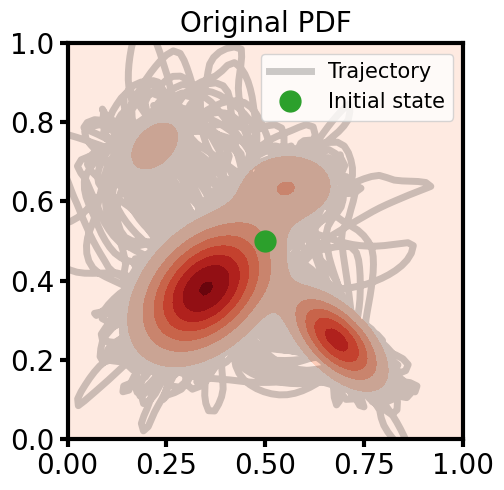

In [2155]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=100, tight_layout=True)
ax.set_aspect('equal')
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
ax.set_title('Original PDF')
ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='Reds')
ax.plot(f[::10,0], f[::10,1], linestyle='-', marker='', color='k', alpha=0.2, label='Trajectory')
ax.plot(f[0,0], f[0,1], linestyle='', marker='o', markersize=15, color='C2', alpha=1.0, label='Initial state')
ax.legend(loc=1)

plt.show()
plt.close()

2025-08-15 10:41:02,808 |  WARNING | legend.py:1323 | No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


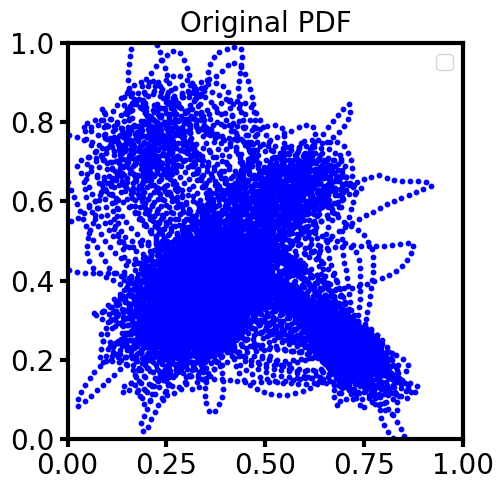

In [2156]:
mu_samples = sample_from_density_2d(pdf_vals.reshape(num_grid, num_grid), grids_x, grids_y, n_samples = f.shape[0])
fig, ax = plt.subplots(figsize=(6, 5), dpi=100, tight_layout=True)
ax.set_aspect('equal')
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
ax.set_title('Original PDF')
#ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='Reds')
ax.scatter(f[::10, 0], f[::10, 1], s=10, color='blue')
#ax.scatter(mu_samples[::10, 0], mu_samples[::10, 1], s=10, color='green')
ax.legend(loc=1)
plt.show()
plt.close()

In [2157]:
#### IN the beginning use esact cdf and after the Algorithmn already converged, i.e around 30k steps use Quantile cdf!

In [2158]:
#w1 = compute_wasserstein_2d(pdf_vals.reshape(num_grid, num_grid), grids_x, grids_y, f[:,:])
#Wasserstein.append(w1)
#print(w1)

In [2159]:
mu_samples = sample_from_density_2d(pdf_vals.reshape(num_grid, num_grid), grids_x, grids_y, n_samples = f.shape[0])
optimal = np.sum(np.log(pdf(mu_samples)))
samples = np.sum(np.log(pdf(f)))

In [2160]:
mu_samples_2 = sample_from_density_2d(pdf_vals.reshape(num_grid, num_grid), grids_x, grids_y, n_samples = f.shape[0])


In [2161]:
np.linalg.norm(f[0]- f[1])

0.002000020000200014

In [2162]:
f

array([[0.5   , 0.5   ],
       [0.4987, 0.4985],
       [0.4974, 0.497 ],
       ...,
       [0.1833, 0.7599],
       [0.1842, 0.7582],
       [0.1851, 0.7564]])

In [2163]:
#!python3 -m pip install POT
L_list = np.array([1.0, 1.0])  # boundaries for each dimension
num_grid = 100
grids_x, grids_y = np.meshgrid(
    np.linspace(0, L_list[0], num_grid),
    np.linspace(0, L_list[1], num_grid)
)
grids = np.array([grids_x.ravel(), grids_y.ravel()]).T
pdf_vals = pdf(grids)
def sample_from_density_2d(p_vals, x_grid, y_grid, n_samples = 10000):
    """Sample from 2D density given over meshgrid"""
    H, W = p_vals.shape
    flat_p = p_vals.ravel()
    flat_p /= flat_p.sum()  # Normalize

    indices = np.random.choice(H * W, size=n_samples, p=flat_p)
    x_flat = x_grid.ravel()[indices]
    y_flat = y_grid.ravel()[indices]
    return np.stack([x_flat, y_flat], axis=1)

In [2164]:
import infomeasure as im
mu_samples = sample_from_density_2d(pdf_vals.reshape(num_grid, num_grid), grids_x, grids_y, n_samples = f.shape[0])
mu_samples_test = sample_from_density_2d(pdf_vals.reshape(num_grid, num_grid), grids_x, grids_y, n_samples = f.shape[0])
print(im.kld(f,mu_samples, approach='metric'), 'emp')
print(im.kld(mu_samples_test, mu_samples, approach='metric'), 'opt')

1.4505883328874174 emp
-0.0013124735422991307 opt


In [2165]:
"""#!python3 -m pip install hyppo
from hyppo.ksample import KSample

tests = ["CCA", "RV"]

for test_name in tests:
    print(f"Running KSample with indep_test='{test_name}'")
    ks = KSample(indep_test=test_name)
    stat, pval = ks.test(mu_samples, f)
    print(f"{test_name} stat: {stat:.4f}, p-value: {pval:.4g}\n")"""


'#!python3 -m pip install hyppo\nfrom hyppo.ksample import KSample\n\ntests = ["CCA", "RV"]\n\nfor test_name in tests:\n    print(f"Running KSample with indep_test=\'{test_name}\'")\n    ks = KSample(indep_test=test_name)\n    stat, pval = ks.test(mu_samples, f)\n    print(f"{test_name} stat: {stat:.4f}, p-value: {pval:.4g}\n")'

In [2166]:
from scipy.stats import gaussian_kde
def sanov_upper_bound(f, pdf, bandwidth='scott'):
    """
    Compute Sanov's upper bound on the probability that the empirical distribution of f
    comes from a distribution with density pdf.

    Parameters:
    - f: np.ndarray, shape (n_samples, d), the sample points
    - pdf: callable, function that accepts f[i] and returns pdf(x)
    - bandwidth: str or float, bandwidth method for KDE

    Returns:
    - kl_estimate: float, D_KL(empirical || pdf)
    - bound: float, upper bound on probability under Sanov
    """

    n_samples, d = f.shape

    # Estimate empirical distribution using KDE
    kde_empirical = gaussian_kde(f.T, bw_method=0.001)

    # Evaluate densities at sample points
    p_vals = kde_empirical(f.T) + 1e-12  # empirical density
    q_vals = pdf(f) + 1e-12            # model density

    # KL divergence estimate
    kl_estimate = np.mean(np.log(p_vals / q_vals))

    # Sanov upper bound
    bound = np.exp(-n_samples * kl_estimate)

    return kl_estimate, bound

#kl, bound = sanov_upper_bound(f, pdf)
#print(f"Estimated KL divergence: {kl:.6f}")
#print(f"Sanov upper bound: {bound:.2e}")
#mu_samples = sample_from_density_2d(pdf_vals.reshape(num_grid, num_grid), grids_x, grids_y, n_samples = f.shape[0])
#kl, bound = sanov_upper_bound(mu_samples, pdf)
#print(f"Optimal Estimated KL divergence: {kl:.6f}")
#print(f"Optimal Sanov upper bound: {bound:.2e}")

In [2167]:
def sanov_upper_bound(f, pdf):
    """
    Compute Sanov's upper bound on the probability that the empirical distribution of `f`
    deviates from a reference distribution with density `pdf`.

    Parameters:
    - f: np.ndarray, shape (n_samples, d), the sample points
    - pdf: callable, function that accepts f (N,d) and returns p(x) as (N,) array

    Returns:
    - kl_estimate: float, D_KL(empirical || pdf)
    - bound: float, Sanov upper bound on the probability
    """

    n_samples = f.shape[0]

    # Evaluate target PDF at sample points (theoretical p(x))
    p_vals = pdf(f)
    # Empirical density puts 1/n mass at each point => KL(empirical || pdf)
    kl_estimate = np.log(n_samples) - np.mean(np.log(p_vals))

    # Sanov bound: P(empirical ≈ f) ≤ exp(-n * D_KL)
    bound = np.exp(-n_samples * kl_estimate)

    return kl_estimate, bound

#kl, bound = sanov_upper_bound(f, pdf)
#print(f"Estimated KL divergence: {kl:.6f}")
#print(f"Sanov upper bound: {bound:.2e}")
#mu_samples = sample_from_density_2d(pdf_vals.reshape(num_grid, num_grid), grids_x, grids_y, n_samples = f.shape[0])
#kl, bound = sanov_upper_bound(mu_samples, pdf)
#print(f"Optimal Estimated KL divergence: {kl:.6f}")
#print(f"Optimal Sanov upper bound: {bound:.2e}")

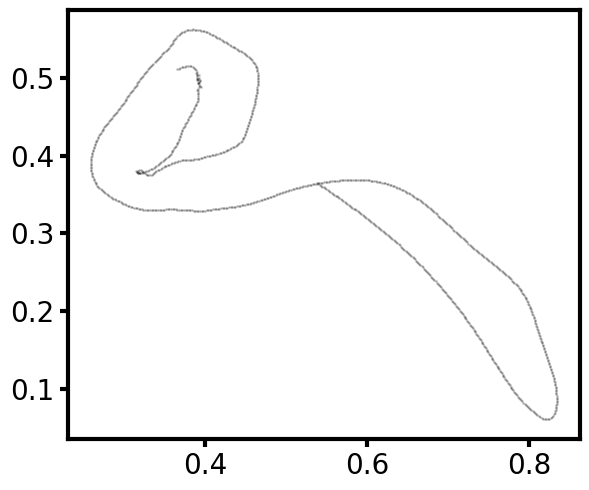

In [2168]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=100, tight_layout=True)
ax.scatter(f[5000:6000,0], f[5000:6000,1], color='k', alpha=0.2, label='Trajectory', s = 1)


In [2169]:
print(optimal, samples)

108898.78125482253 100782.31634164587


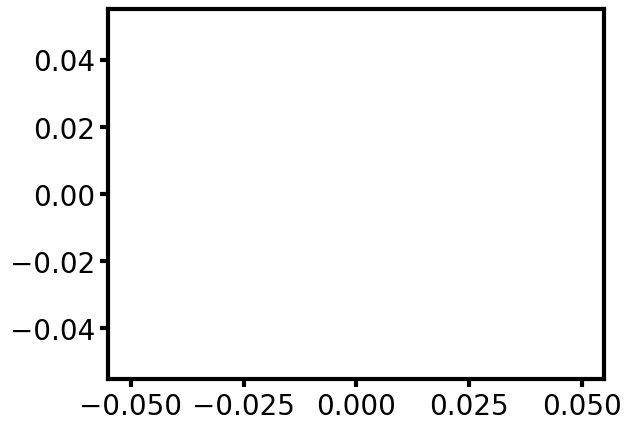

In [2170]:
plt.plot(Wasserstein)
plt.show()

In [2171]:
"""from scipy.stats import gaussian_kde
x, y = f[:, 0], f[:, 1]
#samples_2d = np.random.multivariate_normal(mean=[0, 0], cov=[[1, 0.6], [0.6, 1]], size=1000)
#x, y = samples_2d[:, 0], samples_2d[:, 1]
# KDE estimation
kde = gaussian_kde(np.array([x,y]), bw_method = 'silverman')
# Grid for evaluation
xgrid = np.linspace(x.min()-1, x.max()+1, 400)
ygrid = np.linspace(y.min()-1, y.max()+1, 400)
X, Y = np.meshgrid(xgrid, ygrid)
positions = np.vstack([X.ravel(), Y.ravel()])
Z = kde(positions).reshape(X.shape)
# Plot
plt.contourf(X, Y, Z, levels=50, cmap="viridis")
plt.colorbar(label="Density")
plt.scatter(x, y, s=5, alpha=0.3, color='white')
plt.title("2D Kernel Density Estimate")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()"""

'from scipy.stats import gaussian_kde\nx, y = f[:, 0], f[:, 1]\n#samples_2d = np.random.multivariate_normal(mean=[0, 0], cov=[[1, 0.6], [0.6, 1]], size=1000)\n#x, y = samples_2d[:, 0], samples_2d[:, 1]\n# KDE estimation\nkde = gaussian_kde(np.array([x,y]), bw_method = \'silverman\')\n# Grid for evaluation\nxgrid = np.linspace(x.min()-1, x.max()+1, 400)\nygrid = np.linspace(y.min()-1, y.max()+1, 400)\nX, Y = np.meshgrid(xgrid, ygrid)\npositions = np.vstack([X.ravel(), Y.ravel()])\nZ = kde(positions).reshape(X.shape)\n# Plot\nplt.contourf(X, Y, Z, levels=50, cmap="viridis")\nplt.colorbar(label="Density")\nplt.scatter(x, y, s=5, alpha=0.3, color=\'white\')\nplt.title("2D Kernel Density Estimate")\nplt.xlabel("X")\nplt.ylabel("Y")\nplt.show()'

In [2172]:
import numpy as np

def total_variation_distance(p_samples, q_samples, bins=50, range=[[0, 1], [0, 1]]):
    """
    Computes the total variation distance between two empirical distributions.
    
    Parameters:
        p_samples: np.ndarray of shape (N, 2) — samples from distribution P
        q_samples: np.ndarray of shape (M, 2) — samples from distribution Q
        bins: int or [int, int] — number of bins along each axis
        range: list of 2D bounds — [[x_min, x_max], [y_min, y_max]]
    
    Returns:
        TV distance (float)
    """
    # Compute 2D histograms
    H_p, _ = np.histogramdd(p_samples, bins=bins, range=range, density=True)
    H_q, _ = np.histogramdd(q_samples, bins=bins, range=range, density=True)

    # Bin volume
    vol = np.prod([(r[1] - r[0]) / b for r, b in zip(range, np.atleast_1d(bins))])

    # TV distance
    tv = 0.5 * np.mean(np.abs(H_p - H_q)) * vol
    return tv

#mu_samples = sample_from_density_2d(pdf_vals.reshape(num_grid, num_grid), grids_x, grids_y, n_samples = f.shape[1])
#tv = total_variation_distance(mu_samples, f)
#print(tv)

In [2173]:
import numpy as np
from scipy.stats import wasserstein_distance

def trajectory_to_distance(f, target_samples, n_samples=1000, metric="wasserstein"):
    """
    Computes the distance between the pushforward of the uniform measure by f
    and a target distribution represented by samples.

    Parameters:
        f: function f(t), t in [0,1] -> R^d
        target_samples: array of shape (N, d), samples from target distribution
        n_samples: number of samples to draw from uniform [0,1]
        metric: "wasserstein" or "sinkhorn"

    Returns:
        scalar distance value
    """
    pushed_samples = f
    
    if metric == "wasserstein":
        # Average 1D Wasserstein over dimensions
        d = target_samples.shape[1]
        distances = [
            wasserstein_distance(pushed_samples[:, i], target_samples[:, i])
            for i in range(d)
        ]
        return np.mean(distances)
    
    elif metric == "sinkhorn":
        import ot
        a = np.ones(n_samples) / n_samples
        b = np.ones(target_samples.shape[0]) / target_samples.shape[0]
        M = ot.dist(pushed_samples, target_samples, metric='sqeuclidean')
        return ot.sinkhorn2(a, b, M, reg=0.01)[0]

    else:
        raise ValueError("Unknown metric. Use 'wasserstein' or 'sinkhorn'.")
    
#trajectory_to_distance(f, mu_samples, metric = 'wasserstein')